<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QiskitAer_Applyingnoisetocustomunitarygates_mkbahk_20251222.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip uninstall qiskit qiskit-aer qiskit-aer-gpu qiskit-ibm-runtime -y

Found existing installation: qiskit 2.2.3
Uninstalling qiskit-2.2.3:
  Successfully uninstalled qiskit-2.2.3
Found existing installation: qiskit-aer 0.17.1
Uninstalling qiskit-aer-0.17.1:
  Successfully uninstalled qiskit-aer-0.17.1
Found existing installation: qiskit-aer-gpu 0.15.1
Uninstalling qiskit-aer-gpu-0.15.1:
  Successfully uninstalled qiskit-aer-gpu-0.15.1
Found existing installation: qiskit-ibm-runtime 0.44.0
Uninstalling qiskit-ibm-runtime-0.44.0:
  Successfully uninstalled qiskit-ibm-runtime-0.44.0


In [1]:
!pip install qiskit[visualization]
!pip install qiskit-aer
#!pip install qiskit-aer-gpu==0.15.1
!pip install qiskit-ibm-runtime

  Using cached qiskit_aer-0.17.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.3 kB)
Using cached qiskit_aer-0.17.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
  Using cached qiskit_ibm_runtime-0.44.0-py3-none-any.whl.metadata (21 kB)
Using cached qiskit_ibm_runtime-0.44.0-py3-none-any.whl (1.5 MB)


In [3]:
%pip show qiskit
%pip show qiskit-aer
#%pip show qiskit-aer-gpu
%pip show qiskit-ibm-runtime

Name: qiskit
Version: 2.2.3
Summary: An open-source SDK for working with quantum computers at the level of extended quantum circuits, operators, and primitives.
Home-page: https://www.ibm.com/quantum/qiskit
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: dill, numpy, rustworkx, scipy, stevedore, typing-extensions
Required-by: qiskit-aer, qiskit-ibm-runtime
Name: qiskit-aer
Version: 0.17.2
Summary: Aer - High performance simulators for Qiskit
Home-page: https://github.com/Qiskit/qiskit-aer
Author: AER Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: numpy, psutil, python-dateutil, qiskit, scipy
Required-by: 
Name: qiskit-ibm-runtime
Version: 0.44.0
Summary: IBM Quantum client for Qiskit Runtime.
Home-page: 
Author: 
Author-email: Qiskit Development Team <qiskit@us.ibm.com>
License: Apache 2.0
Location: /usr/loc

In [7]:
from qiskit import transpile, QuantumCircuit
import qiskit.quantum_info as qi

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error

from qiskit.visualization import plot_histogram

In [8]:
# CNOT matrix operator with qubit-0 as control and qubit-1 as target
cx_op = qi.Operator([[1, 0, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]])

# iSWAP matrix operator
iswap_op = qi.Operator([[1, 0, 0, 0],
                        [0, 0, 1j, 0],
                        [0, 1j, 0, 0],
                        [0, 0, 0, 1]])

In [9]:
# CNOT in terms of iSWAP and single-qubit gates
cx_circ = QuantumCircuit(2, name='cx<iSWAP>')

# Add gates
cx_circ.sdg(1)
cx_circ.h(1)
cx_circ.sdg(0)
cx_circ.unitary(iswap_op, [0, 1], label='iswap')
cx_circ.sdg(0)
cx_circ.h(0)
cx_circ.sdg(0)
cx_circ.unitary(iswap_op, [0, 1], label='iswap')
cx_circ.s(1)

print(cx_circ)

     ┌─────┐     ┌────────┐┌─────┐┌───┐┌─────┐┌────────┐     
q_0: ┤ Sdg ├─────┤0       ├┤ Sdg ├┤ H ├┤ Sdg ├┤0       ├─────
     ├─────┤┌───┐│  iswap │└─────┘└───┘└─────┘│  iswap │┌───┐
q_1: ┤ Sdg ├┤ H ├┤1       ├───────────────────┤1       ├┤ S ├
     └─────┘└───┘└────────┘                   └────────┘└───┘


In [10]:
# Simulate the unitary for the circuit using Operator:
unitary = qi.Operator(cx_circ)
print(unitary)

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [11]:
f_ave = qi.average_gate_fidelity(cx_op, unitary)
print("Average Gate Fidelity: F = {:f}".format(f_ave))

Average Gate Fidelity: F = 1.000000


In [12]:
'unitary' in AerSimulator().configuration().basis_gates


True

In [13]:
# Error parameters
param_q0 = 0.05  # damping parameter for qubit-0
param_q1 = 0.1   # damping parameter for qubit-1

# Construct the error
qerror_q0 = amplitude_damping_error(param_q0)
qerror_q1 = amplitude_damping_error(param_q1)
iswap_error = qerror_q1.tensor(qerror_q0)

# Build the noise model by adding the error to the "iswap" gate
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(iswap_error, 'iswap')


In [14]:
noise_model.add_basis_gates(['unitary'])
print(noise_model.basis_gates)

['cx', 'id', 'rz', 'sx', 'unitary']


In [15]:
# Bell state circuit where iSWAPS should be inserted at barrier locations
bell_circ = QuantumCircuit(2, 2, name='bell')
bell_circ.h(0)
bell_circ.append(cx_circ, [0, 1])
bell_circ.measure([0,1], [0,1])
print(bell_circ)

     ┌───┐┌────────────┐┌─┐   
q_0: ┤ H ├┤0           ├┤M├───
     └───┘│  cx<iSWAP> │└╥┘┌─┐
q_1: ─────┤1           ├─╫─┤M├
          └────────────┘ ║ └╥┘
c: 2/════════════════════╩══╩═
                         0  1 


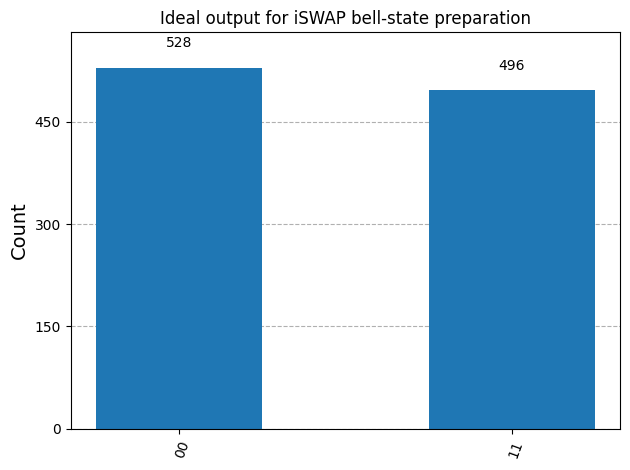

In [16]:
# Create ideal simulator backend and transpile circuit
sim_ideal = AerSimulator()
tbell_circ = transpile(bell_circ, sim_ideal)

ideal_result = sim_ideal.run(tbell_circ).result()
ideal_counts = ideal_result.get_counts(0)
plot_histogram(ideal_counts,
               title='Ideal output for iSWAP bell-state preparation')


In [18]:
# Create noisy simulator and transpile circuit
sim_noise = AerSimulator(noise_model=noise_model)
tbell_circ_noise = transpile(bell_circ, sim_noise)

# Run on the simulator without noise
noise_result = sim_noise.run(tbell_circ_noise).result()
noise_counts = noise_result.get_counts(bell_circ)
plot_histogram(noise_counts,
               title='Noisy output for iSWAP bell-state preparation')

PanicException: internal error: entered unreachable code: Having a unitary result from an `EquivalenceLibrary is not possible